# What do you like in board games - Text Mining and Sentiment Analysis Project

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from tqdm import tqdm
tqdm.pandas()
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
from tqdm.notebook import tqdm
import spacy
import en_core_web_sm

from gensim.models import LdaMulticore
from gensim.models import LdaModel
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


# 1. Dataset Preparation

In [ ]:
data = pd.read_csv('bgg-15m-reviews.csv')
df = data.drop(columns=["Unnamed: 0", 'user', 'ID'])
df.count()

rating     15823269
comment     2995023
name       15823269
dtype: int64

In [ ]:
# Removing the rows without comments
df = df[df.comment.notna()]

# Removing the non ascii comments
df = df[df['comment'].map(lambda x: x.isascii())]

# Counting the words
df['word_count'] = df.comment.str.split().str.len()

# Round the ratings
df['rating'] = df.rating.apply(lambda x: round(x))
df

,rating,comment,name,word_count
2,10,I tend to either love or easily tire of co-op ...,Pandemic,73
4,10,This is an amazing co-op game. I play mostly ...,Pandemic,59
5,10,Hey! I can finally rate this game I've been pl...,Pandemic,215
8,10,Love it- great fun with my son. 2 plays so far...,Pandemic,16
9,10,"Fun, fun game. Strategy is required, but defin...",Pandemic,99
...,...,...,...,...
15823240,10,Buy it..... please,Company of Heroes,3
15823242,10,KS Collector's Bundle with a friend of mine,Company of Heroes,8
15823247,10,Belekokio Gerumo...,Company of Heroes,2
15823264,8,Turn based preview looks very promising. The g...,Company of Heroes,95


In [ ]:
# Keeping the comments that contains more than 10 words
df = df[(df.word_count > 10)]
df

,rating,comment,name,word_count
2,10,I tend to either love or easily tire of co-op ...,Pandemic,73
4,10,This is an amazing co-op game. I play mostly ...,Pandemic,59
5,10,Hey! I can finally rate this game I've been pl...,Pandemic,215
8,10,Love it- great fun with my son. 2 plays so far...,Pandemic,16
9,10,"Fun, fun game. Strategy is required, but defin...",Pandemic,99
...,...,...,...,...
15823218,7,This is a game that sneaks up on you with its ...,Beasty Borders,24
15823221,7,"Nice little abstract strategy, only played onc...",Beasty Borders,47
15823224,7,"Straightforward 2p abstract, lifted by the bea...",Beasty Borders,26
15823230,6,This is a cute but silly game. It is heavily l...,Beasty Borders,24


## 1.1 Resampling

In [ ]:
df.rating.value_counts(sort=True)

8     493525
7     424522
6     398021
9     185593
5     166703
10    118681
4     107280
3      55920
2      31353
1      14824
0          5
Name: rating, dtype: int64

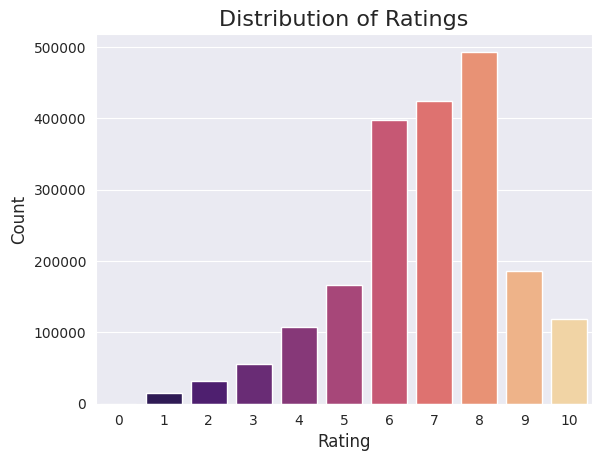

In [ ]:
# Plot the distribution
df.rating.value_counts()

sns.set_style("darkgrid")
sns.countplot(x="rating", data=df, palette="magma")

plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

In [ ]:
df_class_0 = df[df['rating'] == 0]
df_class_1 = df[df['rating'] == 1]
df_class_2 = df[df['rating'] == 2]
df_class_3 = df[df['rating'] == 3]
df_class_4 = df[df['rating'] == 4]
df_class_5 = df[df['rating'] == 5]
df_class_6 = df[df['rating'] == 6]
df_class_7 = df[df['rating'] == 7]
df_class_8 = df[df['rating'] == 8]
df_class_9 = df[df['rating'] == 9]
df_class_10 = df[df['rating'] == 10]

In [ ]:
# All the classes are sampled into the length of a class with minimum size i.e "df_class_1" for balancing the data.

df_rating_2_under = df_class_2.sample(len(df_class_1))
df_rating_3_under = df_class_3.sample(len(df_class_1))
df_rating_4_under = df_class_4.sample(len(df_class_1))
df_rating_5_under = df_class_5.sample(len(df_class_1))
df_rating_6_under = df_class_6.sample(len(df_class_1))
df_rating_7_under = df_class_7.sample(len(df_class_1))
df_rating_8_under = df_class_8.sample(len(df_class_1))
df_rating_9_under = df_class_9.sample(len(df_class_1))
df_rating_10_under = df_class_10.sample(len(df_class_1))

df_under = pd.concat([ df_class_1, df_rating_2_under, df_rating_3_under, df_rating_4_under, df_rating_5_under, df_rating_6_under, df_rating_7_under, df_rating_8_under, df_rating_9_under, df_rating_10_under], axis=0)

print('Size after Random under-sampling:',len(df_under))

Size after Random under-sampling: 148240


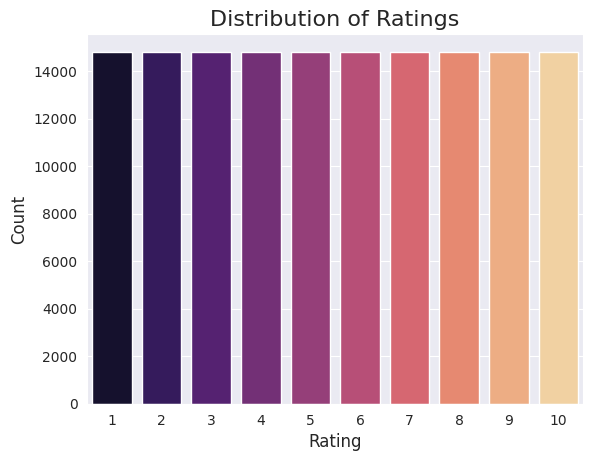

In [ ]:
# Plot the distribution
df_under.rating.value_counts()

sns.set_style("darkgrid")
sns.countplot(x="rating", data=df_under, palette="magma")

plt.title("Distribution of Ratings", fontsize=16)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

plt.show()

## 1.2 Assigning label

In [ ]:
# Assign a label: 1 if the comment is positive (rating>5), 0 otherwise

def label(y):
    if y > 5:
        return 1
    else:
        return 0

df_under['y'] = df_under['rating'].progress_map(label)

df_under = df_under[['name', 'comment', 'y', 'rating']]
df_under

100%|██████████| 148240/148240 [00:00<00:00, 434274.96it/s]


,name,comment,y,rating
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1
...,...,...,...,...
3979674,The 7th Continent,This actually feels like a survival/exploratio...,1,10
5389727,Ascension: Deckbuilding Game,I play the iOS version and have most of the ex...,1,10
14585728,Gnomopolis,"I am one of the designers, and also a fan of t...",1,10
13161598,Infinity,"Love the miniatures, love the fact that it's ...",1,10


In [ ]:
df_under.y.value_counts()

0    74120
1    74120
Name: y, dtype: int64

## 1.3 Cleaning the texts

In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = re.sub('[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespaces
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [ ]:
df_under['clean_review'] = df_under.comment.apply(lambda x: clean_text(x))
df_under

,name,comment,y,rating,clean_review
2143987,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...
2143989,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...
2143990,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...
2143994,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...
2143997,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...
...,...,...,...,...,...
3979674,The 7th Continent,This actually feels like a survival/exploratio...,1,10,actually feel like survivalexploration adventu...
5389727,Ascension: Deckbuilding Game,I play the iOS version and have most of the ex...,1,10,play io version expansion promo deck ive play ...
14585728,Gnomopolis,"I am one of the designers, and also a fan of t...",1,10,one designer also fan game even many test vari...
13161598,Infinity,"Love the miniatures, love the fact that it's ...",1,10,love miniature love fact largely squad base t...


# 2. Aspects Classification

## 2.1 LDA

In [ ]:
def word_tokenizer(text):
    text = text.lower()
    text = text.split()
    return text

df_under['clean_review2'] = df_under['clean_review'].progress_map(word_tokenizer)

100%|██████████| 148240/148240 [00:01<00:00, 116751.90it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ..."
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man..."
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie..."
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla..."
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam..."


In [ ]:
data_words = df_under['clean_review2'].values.tolist()
len(data_words)

148240

In [ ]:
import gensim.corpora as corpora

# Create dictionary where each unique word in 'data_words' is assigned a unique numeric ID
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [ ]:
# Number of topics = Number of aspects
# Aspects: ["general", "luck", "bookkeeping", "downtime", "interaction", "bash the leader", "complicated vs complex"]
num_topics = 7

# Build LDA model
lda_model = LdaMulticore(corpus=corpus, id2word=id2word,
                     num_topics=num_topics, iterations=400)

# Print the keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"game" + 0.027*"like" + 0.025*"version" + 0.017*"better" + '
  '0.016*"play" + 0.014*"original" + 0.012*"much" + 0.010*"rat" + '
  '0.010*"expansion" + 0.009*"good"'),
 (1,
  '0.046*"game" + 0.017*"rule" + 0.011*"play" + 0.008*"make" + 0.007*"great" + '
  '0.007*"one" + 0.006*"system" + 0.006*"ha" + 0.005*"expansion" + '
  '0.005*"war"'),
 (2,
  '0.044*"game" + 0.026*"card" + 0.023*"play" + 0.023*"player" + 0.015*"one" + '
  '0.014*"star" + 0.013*"get" + 0.010*"win" + 0.007*"b" + 0.006*"go"'),
 (3,
  '0.073*"game" + 0.019*"play" + 0.016*"player" + 0.013*"great" + 0.013*"like" '
  '+ 0.012*"really" + 0.011*"fun" + 0.011*"make" + 0.009*"feel" + '
  '0.008*"theme"'),
 (4,
  '0.031*"outstanding" + 0.020*"de" + 0.012*"e" + 0.012*"la" + 0.011*"pirate" '
  '+ 0.010*"que" + 0.009*"el" + 0.009*"con" + 0.008*"husband" + 0.008*"juego"'),
 (5,
  '0.098*"game" + 0.074*"play" + 0.019*"time" + 0.019*"love" + 0.018*"one" + '
  '0.016*"fun" + 0.015*"great" + 0.015*"get" + 0.011*"really" +

## 2.2 Fasttext - Gensim Library

In [ ]:
from gensim.models import FastText
unsuper_model = FastText(data_words, vector_size=100, window=5, min_count=5, workers=4, sg=1)

### fasttext_list

In [ ]:
aspects_list = ['general', 'luck', 'bookkeeping', 'downtime', 'interaction', 'bash the leader', 'complicated vs complex']

In [ ]:
def get_max_similarity(text, aspects):
    try:
        text = " ".join(text)
        similarity_scores = [(aspect, unsuper_model.wv.n_similarity(text, aspect)) for aspect in aspects]
        max_aspect, max_score = max(similarity_scores, key=lambda x: x[1])
        return max_aspect
    except:
        return None

In [ ]:
df_under['fasttext_list'] = df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_list))

100%|██████████| 148240/148240 [37:00<00:00, 66.75it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",general
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",general
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader


In [ ]:
df_under['fasttext_list'].value_counts()

general                   115840
bash the leader            17600
complicated vs complex      6772
bookkeeping                 4607
interaction                 3004
luck                         228
downtime                     185
Name: fasttext_list, dtype: int64

### fasttext_list2

In [ ]:
# Same procedure as before, but "general" will be assigned later with a threshold

aspects_list = ['luck', 'bookkeeping', 'downtime', 'interaction', 'bash the leader', 'complicated vs complex']

def get_max_similarity(text, aspects):
    try:
        text = " ".join(text)
        similarity_scores = [(aspect, unsuper_model.wv.n_similarity(text, aspect)) for aspect in aspects]
        max_aspect, max_score = max(similarity_scores, key=lambda x: x[1])
        return max_aspect, max_score
    except:
        return None, None

In [ ]:
df_under['fasttext_list2'], df_under['fasttext_list2_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_list)))

100%|██████████| 148240/148240 [31:37<00:00, 78.12it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_list2_score
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,bash the leader,0.937172
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",general,bash the leader,0.928523
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",general,complicated vs complex,0.948274
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,bookkeeping,0.915857
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,0.963684


In [ ]:
df_under['fasttext_list2'].value_counts()

bash the leader           85905
bookkeeping               24415
interaction               18600
complicated vs complex    15670
downtime                   3415
luck                        231
Name: fasttext_list2, dtype: int64

In [ ]:
# Compute the average similarity score for each aspect
aspect_scores_mean = df_under.groupby('fasttext_list2')['fasttext_list2_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_list2')['fasttext_list2_score'].std()

In [ ]:
# Iterate over each aspect and update 'fasttext_list' column
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_list2'] == aspect) & (df_under['fasttext_list2_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_list2'] = 'general'

In [ ]:
df_under['fasttext_list2'].value_counts()

general                   129841
bash the leader            11345
bookkeeping                 3029
interaction                 2313
complicated vs complex      1217
downtime                     462
luck                          29
Name: fasttext_list2, dtype: int64

### fasttext_dict

In [ ]:
df_under.drop('fasttext_list2_score', axis=1, inplace=True)

In [ ]:
aspects_dict = {
    'luck': ['luck', 'alea', 'unpredictable', 'game elements', 'random', 'chance'],
    'bookkeeping': ['manual recording', 'data', 'rulebook', 'reference', 'check'],
    'downtime': ['waiting time', 'unproductive', 'player turn', 'nothing to do'],
    'interaction': ['interaction','influence', 'player actions', 'other participants'],
    'bash the leader': ['prevent victory', 'take actions', 'against leader', 'sacrifice'],
    'complicated vs complex': ['complicated', 'rules', 'exceptions', 'complex', 'repercussions', 'difficult to predict']
}

In [ ]:
df_under['fasttext_dict'], df_under['fasttext_dict_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_dict)))

100%|██████████| 148240/148240 [31:31<00:00, 78.35it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_dict_score
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"[thing, shouldnt, oughta, game, illconceived, ...",general,general,bash the leader,0.937172
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"[sure, game, hilarious, first, time, play, man...",general,general,bash the leader,0.928523
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"[one, wretched, game, experience, ive, experie...",general,general,complicated vs complex,0.948274
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"[ugh, game, adult, equivalent, kid, swear, pla...",general,general,bookkeeping,0.915857
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"[thumbsdown, herpes, tabletop, game, even, gam...",bash the leader,bash the leader,bash the leader,0.963684


In [ ]:
df_under['fasttext_dict'].value_counts()

bash the leader           85905
bookkeeping               24415
interaction               18600
complicated vs complex    15670
downtime                   3415
luck                        231
Name: fasttext_dict, dtype: int64

In [ ]:
aspect_scores_mean = df_under.groupby('fasttext_dict')['fasttext_dict_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_dict')['fasttext_dict_score'].std()

In [ ]:
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_dict'] == aspect) & (df_under['fasttext_dict_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_dict'] = 'general'

In [ ]:
df_under['fasttext_dict'].value_counts()

general                   129841
bash the leader            11345
bookkeeping                 3029
interaction                 2313
complicated vs complex      1217
downtime                     462
luck                          29
Name: fasttext_dict, dtype: int64

### fasttext_full

In [ ]:
aspects_dict_full = {
    'luck': ['alea, all those game elements independent of player intervention, introduced by game mechanics outside the control of the players.'],
    'bookkeeping': ['manual recording of data and potentially automatic or semi-automatic game processes, including also the need of continuosly accessing the rulebook for reference'],
    'downtime': ['unproductive waiting time between one player turn and the next. By unproductive we mean not only having nothing (or little) to do, but also nothing (or little) to think about'],
    'interaction': ['the degree of influence that one player\'s actions have on the actions of the other participants'],
    'bash the leader': ['when, to prevent the victory of whoever is first, the players are forced to take actions against him, often to the detriment of their own advantage or in any case without gaining anything directly. At the table, the unfortunate situation can arise whereby one or more must "sacrifice" themselves to curb the leader and let the others benefit from this conduct'],
    'complicated vs complex': ['A game is complicated the more the rules are quantitatively many and qualitatively equipped with exceptions. Once you understand and learn all the variables, a game (that is only) complicated is not difficult to master. In a complicated game, solving a problem leads to immediate, certain and predictable results. A game is as complex as the repercussions of one\'s actions are difficult to predict and master. Even once you understand and learn all the variables, a complex game is still difficult to master. In a complex game, solving one problem leads to other problems. ']
}

In [ ]:
df_under['fasttext_full'], df_under['fasttext_full_score'] = zip(*df_under['clean_review2'].progress_map(lambda text: get_max_similarity(text, aspects_dict_full)))

100%|██████████| 148240/148240 [1:41:00<00:00, 24.46it/s]


In [ ]:
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_dict_score,fasttext_full,fasttext_full_score
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,bash the leader,bash the leader,0.941606,bash the leader,0.941606
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"['sure', 'game', 'hilarious', 'first', 'time',...",general,general,general,0.925290,bash the leader,0.925290
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",complicated vs complex,bash the leader,bash the leader,0.950048,bash the leader,0.950048
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,0.916220,bash the leader,0.916220
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,0.963154,bash the leader,0.963154


In [ ]:
df_under['fasttext_full'].value_counts()

bash the leader           81751
bookkeeping               31536
interaction               16238
complicated vs complex    14654
downtime                   3784
luck                        277
Name: fasttext_full, dtype: int64

In [ ]:
aspect_scores_mean = df_under.groupby('fasttext_full')['fasttext_full_score'].mean()
aspect_scores_std = df_under.groupby('fasttext_full')['fasttext_full_score'].std()

In [ ]:
for aspect in aspects_list:
    df_under.loc[(df_under['fasttext_full'] == aspect) & (df_under['fasttext_full_score'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'fasttext_full'] = 'general'

In [ ]:
df_under['fasttext_full'].value_counts()

general                   130225
bash the leader            10484
bookkeeping                 3861
interaction                 1994
complicated vs complex      1180
downtime                     496
Name: fasttext_full, dtype: int64

In [ ]:
df_under.drop(['fasttext_dict_score', 'fasttext_full_score'], axis=1, inplace=True)
df_under.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,general,general,general
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"['sure', 'game', 'hilarious', 'first', 'time',...",general,general,general,general
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",general,general,general,general
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,general
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,bash the leader


## 2.3 Fasttext - fastText Library

In [ ]:
df_super = df_under.copy()
df_super.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,general,general,general
1,Cards Against Humanity,"Sure, this game is hilarious the first time yo...",0,1,sure game hilarious first time play many time ...,"['sure', 'game', 'hilarious', 'first', 'time',...",general,general,general,general
2,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",general,general,general,general
3,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,general
4,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,bash the leader


In [ ]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393151 sha256=49bd6e7a727839f4e532fb1feb642b6b944a68c5d2639eee7f752f1791097cd0
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext

train_path = 'train.txt'

# Training the model
super_model = fasttext.train_supervised(input=train_path, epoch=1000)

In [ ]:
# Predictions
df_super['prediction'] = df_super['clean_review'].apply(lambda x: super_model.predict(x)[0][0].replace('__label__', ''))
df_super['confidence'] = df_super['clean_review'].apply(lambda x: super_model.predict(x)[1][0])

# Calculate mean confidence for each label
label_means = df_super.groupby('prediction')['confidence'].mean().reset_index()

std_conf = df_super['confidence'].std()
# Substitute predicted label with 'general' if confidence is smaller than the label's mean confidence
df_super = pd.merge(df_super, label_means, on='prediction', suffixes=('', '_mean'))
df_super.loc[df_super['confidence'] < (df_super['confidence_mean'] + std_conf), 'prediction'] = 'general'

# Drop the mean confidence column
df_super.drop('confidence_mean', axis=1, inplace=True)

df_super

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full,prediction,confidence
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,general,general,general,general,0.894105
1,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",general,general,general,general,general,0.770858
2,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,general,general,0.894105
3,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,bash the leader,general,0.895621
4,Cards Against Humanity,"Because of the subject matter, this deserves ...",0,1,subject matter deserve vilification get wa re...,"['subject', 'matter', 'deserve', 'vilification...",general,general,general,general,general,0.895621
...,...,...,...,...,...,...,...,...,...,...,...,...
148235,CapCom Street Fighter Deck-Building Game,Fun deck building with a lot more take that th...,1,10,fun deck build lot take one cryptozoic fit str...,"['fun', 'deck', 'build', 'lot', 'take', 'one',...",bash the leader,bash the leader,bash the leader,bash the leader,general,0.348536
148236,Power Grid,One of my perennial favourites. Still learning...,1,10,one perennial favourite still learn work trick...,"['one', 'perennial', 'favourite', 'still', 'le...",general,general,general,general,general,0.216599
148237,Puerto Rico,So much love for PR. A must own really for any...,1,10,much love pr must really gamer dont one error ...,"['much', 'love', 'pr', 'must', 'really', 'game...",general,general,general,general,general,0.323947
148238,Empires of the Void II,Love the design. Like the mechanism. Score = E...,1,10,love design like mechanism score eelg pt victo...,"['love', 'design', 'like', 'mechanism', 'score...",general,general,general,general,general,0.284826


In [ ]:
df_super['prediction'].value_counts()

general                   139702
luck_alea                   3242
downtime                    2627
bookkeeping                 2286
complicated_vs_complex       336
interaction                   42
bash_leader                    5
Name: prediction, dtype: int64

In [ ]:
# Substitute values in a column
df_under['prediction'] = df_under['prediction'].replace({'bash_leader': 'bash the leader',
                                                         'complicated_vs_complex': 'complicated vs complex',
                                                         'luck_alea': 'luck'})

In [ ]:
# Define the columns for value counts
columns = ['fasttext_list', 'fasttext_list2', 'fasttext_dict', 'fasttext_full', 'prediction']

# Perform value counts on specific columns
value_counts = df_under[columns].apply(pd.Series.value_counts)
print(value_counts)

                        fasttext_list  fasttext_list2  fasttext_dict  \
bash the leader                 17600           11345          11345   
bookkeeping                      4607            3029           3029   
complicated vs complex           6772            1217           1217   
downtime                          185             462            462   
general                        115840          129841         129841   
interaction                      3004            2313           2313   
luck                              228              29             29   

                        fasttext_full  prediction  
bash the leader               10484.0           5  
bookkeeping                    3861.0        2286  
complicated vs complex         1180.0         336  
downtime                        496.0        2627  
general                      130225.0      139702  
interaction                    1994.0          42  
luck                              NaN        3242  


## 2.4 Spacy & Nearest Neighbour

In [ ]:
df_under.drop('confidence', axis=1, inplace=True)

In [ ]:
df_spacy = df_under.copy()

In [ ]:
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
def embed(tokens, nlp):
    """Return the centroid of the embeddings for the given tokens.

    Out-of-vocabulary tokens are cast aside. Stop words are also
    discarded. An array of 0s is returned if none of the tokens
    are valid.

    """
    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']
        centroid = np.zeros(width)

    return centroid

In [ ]:
label_names = ['luck random by chance flip a coin',
               'book keeping, manual recording',
               'downtime bore wait',
               'interaction players',
               'bash the leader',
               'complicated complex difficult']

label_vectors = np.asarray([
     embed(label.split(), nlp)
     for label in label_names
 ])

In [ ]:
label_vectors.shape

(6, 300)

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(label_vectors)

NearestNeighbors(n_neighbors=1)

In [ ]:
def predict(doc, nlp, neigh):
    doc = clean_text(doc)
    tokens = doc.split(' ')
    centroid = embed(tokens, nlp)
    distances, indices = neigh.kneighbors([centroid])
    closest_label_index = indices[0][0]
    closest_distance = distances[0][0]

    return label_names[closest_label_index], closest_distance

df_spacy[['spacy_pred', 'closest_distance']] = df_spacy['comment'].apply(lambda x: pd.Series(predict(x, nlp, neigh)))
df_spacy.head()

,name,comment,y,rating,clean_review,clean_review2,fasttext_list,fasttext_list2,fasttext_dict,fasttext_full,prediction,spacy_pred,closest_distance
0,Cards Against Humanity,Some things shouldn't oughta be games. Ill-co...,0,1,thing shouldnt oughta game illconceived garbag...,"['thing', 'shouldnt', 'oughta', 'game', 'illco...",general,general,general,general,general,luck random by chance flip a coin,28.562084
1,Cards Against Humanity,One of the more wretched gaming experiences th...,0,1,one wretched game experience ive experience bi...,"['one', 'wretched', 'game', 'experience', 'ive...",general,general,general,general,general,luck random by chance flip a coin,24.966747
2,Cards Against Humanity,Ugh. This game is the adult equivalent of kids...,0,1,ugh game adult equivalent kid swear playground...,"['ugh', 'game', 'adult', 'equivalent', 'kid', ...",general,general,general,general,general,luck random by chance flip a coin,26.611860
3,Cards Against Humanity,:thumbsdown: The herpes of tabletop gaming. No...,0,1,thumbsdown herpes tabletop game even game real...,"['thumbsdown', 'herpes', 'tabletop', 'game', '...",bash the leader,bash the leader,bash the leader,bash the leader,general,luck random by chance flip a coin,28.089871
4,Cards Against Humanity,"Because of the subject matter, this deserves ...",0,1,subject matter deserve vilification get wa re...,"['subject', 'matter', 'deserve', 'vilification...",general,general,general,general,general,luck random by chance flip a coin,24.786317


In [ ]:
# Substitute values in a column
df_spacy['spacy_pred'] = df_spacy['spacy_pred'].replace({'book keeping, manual recording': 'bookkeeping',
                                                         'complicated complex difficult': 'complicated vs complex',
                                                         'luck random by chance flip a coin': 'luck',
                                                         'downtime bore wait': 'downtime',
                                                         'interaction players': 'interaction'})

In [ ]:
df_spacy['spacy_pred'].value_counts()

luck                      111956
downtime                   14788
interaction                10993
complicated vs complex      9529
bash the leader              681
bookkeeping                  293
Name: spacy_pred, dtype: int64

In [ ]:
aspect_scores_mean = df_spacy.groupby('spacy_pred')['closest_distance'].mean()
aspect_scores_std = df_spacy.groupby('spacy_pred')['closest_distance'].std()

In [ ]:
for aspect in aspects_list:
    df_spacy.loc[(df_spacy['spacy_pred'] == aspect) & (df_spacy['closest_distance'] < (aspect_scores_mean[aspect] + aspect_scores_std[aspect])), 'spacy_pred'] = 'general'

In [ ]:
df_spacy['prediction'].value_counts()

general                   139702
luck_alea                   3242
downtime                    2627
bookkeeping                 2286
complicated_vs_complex       336
interaction                   42
bash_leader                    5
Name: prediction, dtype: int64

In [ ]:
df_spacy.drop('closest_distance', axis=1, inplace=True)
df_under = df_spacy

In [ ]:
# Substitute values in a column
df_under['prediction'] = df_under['prediction'].replace({'bash_leader': 'bash the leader',
                                                         'complicated_vs_complex': 'complicated vs complex',
                                                         'luck_alea': 'luck'})

In [ ]:
# Define the columns for value counts
columns = ['fasttext_list', 'fasttext_list2', 'fasttext_dict', 'fasttext_full', 'prediction', 'spacy_pred']

# Perform value counts on specific columns
value_counts = df_under[columns].apply(pd.Series.value_counts)
sorted_value_counts = value_counts.apply(lambda x: x.sort_values(ascending=False))
print(sorted_value_counts)

                        fasttext_list  fasttext_list2  fasttext_dict  \
bash the leader                 17600           11345          11345   
bookkeeping                      4607            3029           3029   
complicated vs complex           6772            1217           1217   
downtime                          185             462            462   
general                        115840          129841         129841   
interaction                      3004            2313           2313   
luck                              228              29             29   

                        fasttext_full  prediction  spacy_pred  
bash the leader               10484.0           5          79  
bookkeeping                    3861.0        2286          19  
complicated vs complex         1180.0         336        1165  
downtime                        496.0        2627        1803  
general                      130225.0      139702      129170  
interaction                    1994.0  

In [ ]:
df_under.drop(['fasttext_full', 'fasttext_dict'], axis=1, inplace=True)

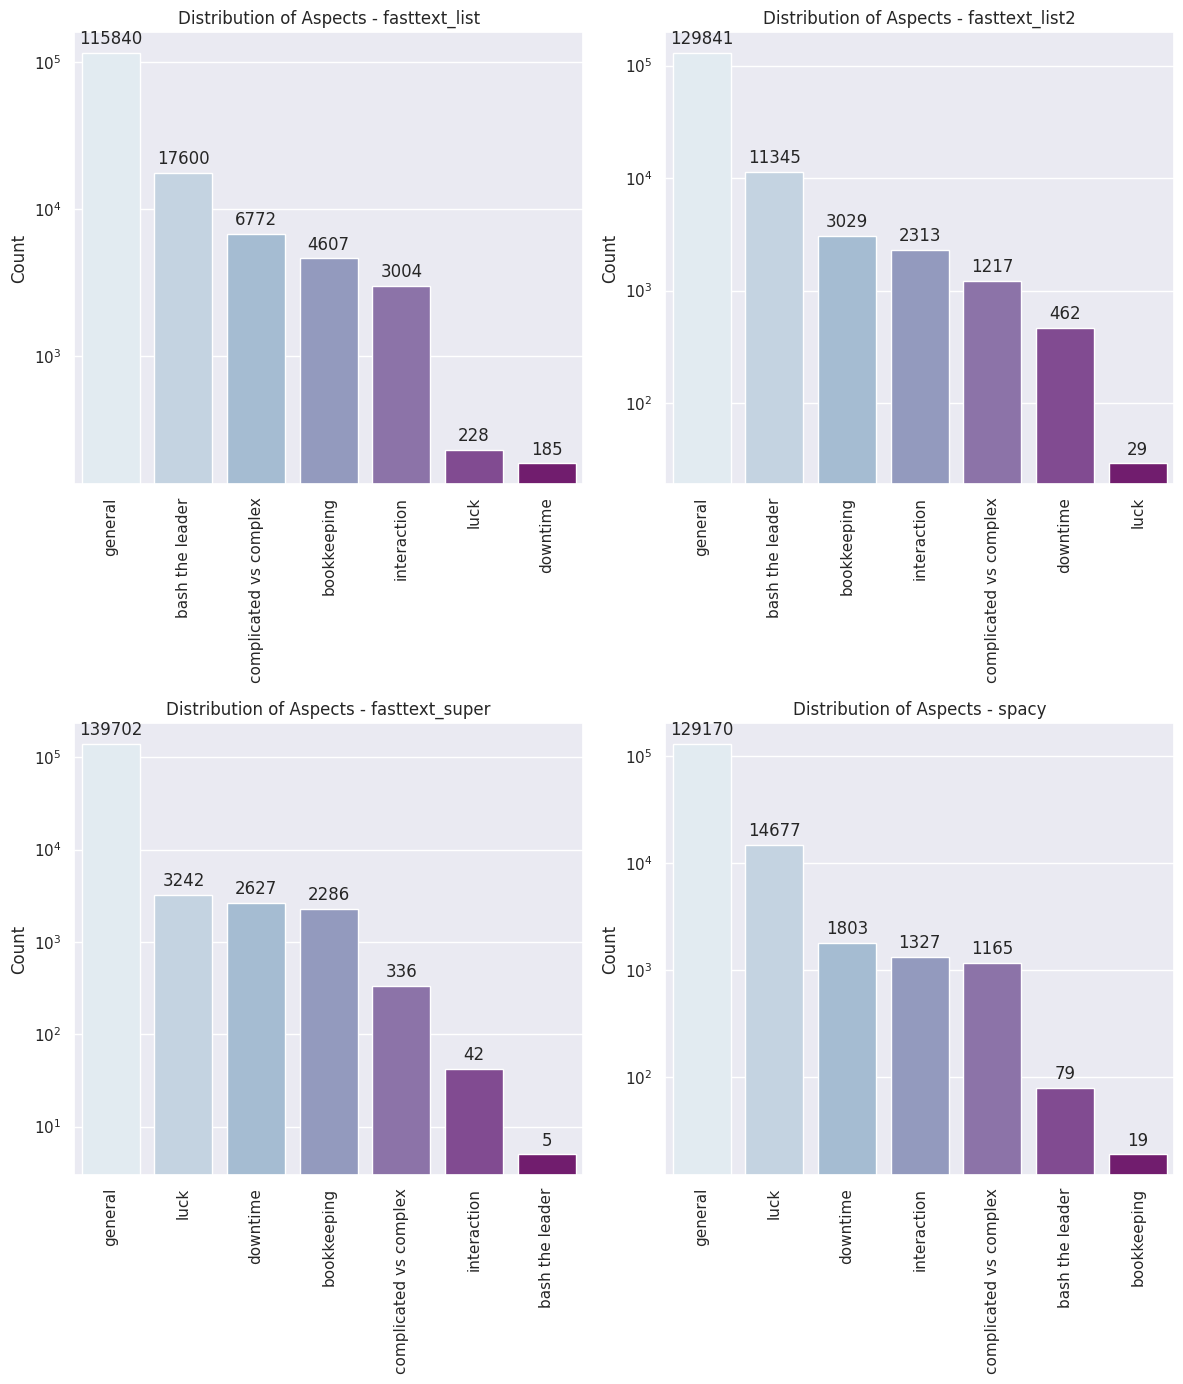

In [ ]:
# Dictionary to map original column names to descriptive labels
column_labels = {
    'fasttext_list': 'fasttext_list',
    'fasttext_list2': 'fasttext_list2',
    'prediction': 'fasttext_super',
    'spacy_pred': 'spacy'
}

# Dictionary to map column names to desired color palettes
column_palettes = {
    'fasttext_list': 'BuPu',
    'fasttext_list2': 'BuPu',
    'prediction': 'BuPu',
    'spacy_pred': 'BuPu'
}

columns_to_plot = ['fasttext_list', 'fasttext_list2', 'prediction', 'spacy_pred']

sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 14))
axs = axs.flatten()

for i, column in enumerate(columns_to_plot):
    # Calculate the count of each label in the current column
    label_counts = df_under[column].value_counts().sort_values(ascending=False)

    # Create the countplot with value counts labels on the current subplot
    ax = sns.countplot(data=df_under, x=column, order=label_counts.index, ax=axs[i], palette=column_palettes[column])

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Aspects - {column_labels[column]}')

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

# 3. Sentiment Classification

## 3.1 Dataset Preparation

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler

In [ ]:
class Vocabulary:

    def __init__(self, freq_threshold, max_size):
        # Initiate the index to token dict
        ## <PAD> -> padding, used for padding the shorter sentences in a batch to match the length of longest sentence in the batch
        ## <SOS> -> start token, added in front of each sentence to signify the start of sentence
        ## <EOS> -> End of sentence token, added to the end of each sentence to signify the end of sentence
        ## <UNK> -> words which are not found in the vocab are replace by this token
        self.itos = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3: '<UNK>'}
        # Initiate the token to index dict
        self.stoi = {k:j for j,k in self.itos.items()}

        self.freq_threshold = freq_threshold
        self.max_size = max_size

    def __len__(self):
        return len(self.itos)

    '''
    a simple tokenizer to split on space and converts the sentence to list of words
    '''
    @staticmethod
    def tokenizer(text):
        return [tok.lower().strip() for tok in text.split(' ')]

    '''
    build the vocab: create a dictionary mapping of index to string (itos) and string to index (stoi)
    output ex. for stoi -> {'the':5, 'a':6, 'an':7}
    '''
    def build_vocabulary(self, sentence_list):
        # Calculate the frequencies of each word first to remove the words with freq < freq_threshold
        frequencies = {}
        idx = 4 #index from which we want our dict to start. We already used 4 indexes for pad, start, end, unk

        # Calculate freq of words
        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                if word not in frequencies.keys():
                    frequencies[word]=1
                else:
                    frequencies[word]+=1


        # Limit vocab by removing low freq words
        frequencies = {k:v for k,v in frequencies.items() if v>self.freq_threshold}

        # Limit vocab to the max_size specified
        frequencies = dict(sorted(frequencies.items(), key = lambda x: -x[1])[:self.max_size-idx]) # idx =4 for pad, start, end , unk

        # Create vocab
        for word in frequencies.keys():
            self.stoi[word] = idx
            self.itos[idx] = word
            idx+=1


    '''
    convert the list of words to a list of corresponding indexes
    '''
    def numericalize(self, text):
        # Tokenize text
        tokenized_text = self.tokenizer(text)
        numericalized_text = []

        for token in tokenized_text:
            if token in self.stoi.keys():
                numericalized_text.append(self.stoi[token])
            else:
                # Out-of-vocab words are represented by UNK token index
                numericalized_text.append(self.stoi['<UNK>'])

        return numericalized_text

In [ ]:
class CustomDataset(Dataset):
    '''
    Initiating Variables
    df: the training dataframe
    source_column : the name of source text column in the dataframe
    transform : if we want to add any augmentation
    freq_threshold : the minimum times a word must occur in corpus to be treated in vocab
    source_vocab_max_size : max source vocab size
    '''

    def __init__(self, df, source_column,freq_threshold = 3,
                source_vocab_max_size = 10000 , transform=None):

        self.df = df
        self.transform = transform

        # Get source and target texts
        self.source_texts = self.df[source_column]

        ## VOCAB class has been created above
        # Initialize source vocab object and build vocabulary
        self.source_vocab = Vocabulary(freq_threshold, source_vocab_max_size)
        self.source_vocab.build_vocabulary(self.source_texts.tolist())

    def __len__(self):
        return len(self.df)

    '''
    __getitem__ runs on 1 example at a time. Here, we get an example at index and return its numericalize source and
    target values using the vocabulary objects we created in __init__
    '''
    def __getitem__(self, index):
        source_text = self.source_texts[index]

        if self.transform is not None:
            source_text = self.transform(source_text)

        # Numericalize texts ['<SOS>','cat', 'in', 'a', 'bag','<EOS>'] -> [1,12,2,9,24,2]
        numerialized_source = [self.source_vocab.stoi["<SOS>"]]
        numerialized_source += self.source_vocab.numericalize(source_text)
        numerialized_source.append(self.source_vocab.stoi["<EOS>"])

        # Convert the list to tensor and return
        return torch.tensor(numerialized_source), torch.tensor(self.df.y[index])

In [ ]:
# Load the FastText model and dataset
fasttext_model = FastText.load("FastText-Model-For-ABSA.bin")

In [ ]:
dataset = CustomDataset(df_under, "clean_review")
len(dataset.source_vocab.stoi)

10000

## 3.2 Word Embeddings

In [ ]:
def get_emb_layer_with_weights(target_vocab, emb_model, trainable=False):
    # Initialize an empty matrix and a counter
    weights_matrix = np.zeros((len(target_vocab), config.EMB_DIM))
    words_found = 0

    for i, word in enumerate(target_vocab):
        # Concatenate the word embedding for the current word from the embedding model
        weights_matrix[i] = np.concatenate([emb_model.wv[word]])
        words_found += 1

    print(f"Words found are: {words_found}")

    # Convert the weights matrix to a PyTorch tensor
    weights_matrix = torch.tensor(weights_matrix, dtype=torch.float32).reshape(len(target_vocab), config.EMB_DIM)
    # Create an embedding layer from the pre-trained weights matrix
    emb_layer = nn.Embedding.from_pretrained(weights_matrix)

    # Set the embedding layer's weights as trainable or non-trainable based on the 'trainable' flag
    if trainable:
        emb_layer.weight.requires_grad = True
    else:
        emb_layer.weight.requires_grad = False

    return emb_layer


In [ ]:
class MyCollate:

    def __init__(self, pad_idx, maxlen):
        self.pad_idx = pad_idx
        self.maxlen = maxlen

    #__call__: a default method
    ##   First the obj is created using MyCollate(pad_idx) in data loader
    ##   Then if obj(batch) is called -> __call__ runs by default
    def __call__(self, batch):
        # Get all source indexed sentences of the batch
        source = [item[0] for item in batch]
        # Pad them using pad_sequence method from pytorch.
        # source = pad_sequence(source, batch_first=False, padding_value = self.pad_idx)

        padded_sequence = torch.zeros((self.maxlen, len(batch)), dtype = torch.int)

        for idx, text in enumerate(source):
            if len(text) > self.maxlen:
                padded_sequence[:, idx] = source[idx][: self.maxlen]
            else:
                padded_sequence[:len(source[idx]), idx] = padded_sequence[:len(source[idx]), idx] + source[idx]

        # Get all target indexed sentences of the batch
        target = [item[1] for item in batch]

        target = torch.tensor(target, dtype = torch.float32).reshape(-1)
        return padded_sequence, target

## 3.3 Initializing the Model

In [ ]:
class config:
    warnings.filterwarnings("ignore", category = UserWarning)
    IMG_SIZE = (224,224)
    DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
    FOLDS = 5
    SHUFFLE = True
    BATCH_SIZE = 32
    LR = 0.01
    EPOCHS = 15
    EMB_DIM = 100
    MAX_LEN = 20
    MODEL_PATH = "./Models/MyModel.pt"

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, embedding_layer):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = embedding_layer  # Initialize the embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)  # Bidirectional LSTM layer
        self.fc1 = nn.Linear(2 * hidden_dim, 128)  # Fully connected layer 1
        self.fc2 = nn.Linear(128, output_dim)  # Fully connected layer 2
        self.dropout = nn.Dropout(0.3)  # Dropout layer to prevent overfitting
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def forward(self, text):
        max_len, N = text.shape  # Get the shape of the input text
        hidden = torch.zeros((2, N, self.hidden_dim), dtype=torch.float)  # Initialize hidden state
        memory = torch.zeros((2, N, self.hidden_dim), dtype=torch.float)  # Initialize memory state
        hidden = hidden.to(config.DEVICE)  # Move hidden state to the specified device (GPU or CPU)
        memory = memory.to(config.DEVICE)

In [ ]:
# Function responsible for training the model for a single epoch
# Computes the loss, backpropagates gradients, and updates the model's weights based on the specified optimizer.
# Keeps track of the training loss and the number of correct predictions during training.

def train_epochs(dataloader,model, loss_fn, optimizer):
    train_correct = 0
    train_loss = 0

    model.train()

    for review, label in tqdm(dataloader):

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)
        optimizer.zero_grad()
        output = model(review)
        output = output.reshape(-1)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        train_correct += (prediction == label).float().sum()

    return train_loss, train_correct

In [ ]:
# Used for validation during the training process, but it doesn't perform backpropagation or weight updates.
# Instead, it computes the validation loss and keeps track of the number of correct predictions.

def val_epochs(dataloader, model, loss_fn):
    val_correct = 0
    val_loss = 0

    model.eval()

    for review, label in dataloader:

        review, label = review.to(config.DEVICE), label.to(config.DEVICE)

        output = model(review)
        output = output.reshape(-1)

        loss = loss_fn(output, label)

        val_loss += loss.item()*review.size(1)
        prediction = (output > 0.5).float()
        val_correct += (prediction == label).float().sum()

    return val_loss, val_correct

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Create K-Fold cross-validation object
kfold = KFold(n_splits=config.FOLDS)
model_state_dicts = {}

# Initialize variables and lists

best_model_state_dict = None
best_train_acc = 0.0
best_val_acc = 0.0

train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(dataset)))):

    # Create data samplers for training and validation based on fold indices
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # Create data loaders for training and validation
    train_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=train_sampler,
                              collate_fn=MyCollate(0, config.MAX_LEN))
    val_loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, sampler=val_sampler,
                            collate_fn=MyCollate(0, config.MAX_LEN))

    # Define model architecture
    VOCAB_SIZE = len(dataset.source_vocab)
    HIDDEN_DIM = 128
    OUTPUT_DIM = 1
    VOCAB = list(dataset.source_vocab.stoi)

    embedding_layer = get_emb_layer_with_weights(target_vocab=VOCAB, emb_model=fasttext_model, trainable=False)

    model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
    model = model.to(config.DEVICE)

    # Define loss function and optimizer
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"-----------------------------------------------------------{fold}-fold of the model-----------------------------------------------------------")

    # Training loop for multiple epochs
    for epoch in range(config.EPOCHS):
        train_loss, train_correct = train_epochs(train_loader, model, loss_fn, optimizer)
        val_loss, val_correct = val_epochs(val_loader, model, loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        val_loss = val_loss / len(val_loader.sampler)
        train_acc = (train_correct / len(train_loader.sampler)) * 100
        val_acc = (val_correct / len(val_loader.sampler)) * 100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu().numpy().tolist())
        val_accs.append(val_acc.cpu().numpy().tolist())

        print(f"| Train Loss : {train_loss} |", end=" ")
        print(f" Val Loss : {val_loss} |", end=" ")
        print(f"Train Acc : {train_acc} |", end=" ")
        print(f"Val Acc : {val_acc} |")

    # Store the training and validation metrics for this fold
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accs_list.append(train_accs)
    val_accs_list.append(val_accs)

    # Keep track of the best model based on validation accuracy
    if train_acc > best_train_acc and val_acc > best_val_acc:
        best_train_acc = train_acc
        best_val_acc = val_acc
        best_model_state_dict = model.state_dict()
        best_model = model

Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------0-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:26<00:00, 25.32it/s]


| Train Loss : 0.6190911590474011 |  Val Loss : 0.5845072753868165 | Train Acc : 65.9192886352539 | Val Acc : 77.3374252319336 |


100%|██████████| 3706/3706 [02:50<00:00, 21.72it/s]


| Train Loss : 0.5354197977590226 |  Val Loss : 0.7556235880962399 | Train Acc : 72.75617218017578 | Val Acc : 56.202781677246094 |


100%|██████████| 3706/3706 [02:38<00:00, 23.33it/s]


| Train Loss : 0.5188017658571649 |  Val Loss : 0.8372914687852504 | Train Acc : 73.775634765625 | Val Acc : 48.77225875854492 |


100%|██████████| 3706/3706 [02:24<00:00, 25.63it/s]


| Train Loss : 0.5094854889394332 |  Val Loss : 0.597286633813439 | Train Acc : 74.3878173828125 | Val Acc : 70.35213470458984 |


100%|██████████| 3706/3706 [02:22<00:00, 25.95it/s]


| Train Loss : 0.5033888785551511 |  Val Loss : 0.8232881689933719 | Train Acc : 74.57754516601562 | Val Acc : 48.75876998901367 |


100%|██████████| 3706/3706 [02:28<00:00, 24.99it/s]


| Train Loss : 0.49742434151707887 |  Val Loss : 0.6237084081349216 | Train Acc : 75.10456085205078 | Val Acc : 64.52374267578125 |


100%|██████████| 3706/3706 [02:28<00:00, 25.00it/s]


| Train Loss : 0.49289215460652863 |  Val Loss : 0.5758540397615479 | Train Acc : 75.39715576171875 | Val Acc : 69.6438217163086 |


100%|██████████| 3706/3706 [02:31<00:00, 24.46it/s]


| Train Loss : 0.4891169107706561 |  Val Loss : 0.7327209971624005 | Train Acc : 75.54810333251953 | Val Acc : 58.77630615234375 |


100%|██████████| 3706/3706 [02:28<00:00, 24.89it/s]


| Train Loss : 0.4851742890224673 |  Val Loss : 0.7539777456909916 | Train Acc : 75.8752670288086 | Val Acc : 56.5333251953125 |


100%|██████████| 3706/3706 [02:25<00:00, 25.44it/s]


| Train Loss : 0.4823432776793492 |  Val Loss : 0.5918447776092945 | Train Acc : 76.16197204589844 | Val Acc : 68.73650360107422 |


100%|██████████| 3706/3706 [02:26<00:00, 25.31it/s]


| Train Loss : 0.4796759645865212 |  Val Loss : 0.6580429972665605 | Train Acc : 76.28002166748047 | Val Acc : 60.523475646972656 |


100%|██████████| 3706/3706 [02:26<00:00, 25.31it/s]


| Train Loss : 0.4777530618313513 |  Val Loss : 0.6501530597033658 | Train Acc : 76.50853729248047 | Val Acc : 64.6215591430664 |


100%|██████████| 3706/3706 [02:23<00:00, 25.89it/s]


| Train Loss : 0.47530667814720146 |  Val Loss : 0.4242402609624672 | Train Acc : 76.6004409790039 | Val Acc : 81.18928527832031 |


100%|██████████| 3706/3706 [02:23<00:00, 25.79it/s]


| Train Loss : 0.47331506399869017 |  Val Loss : 0.5069778995036565 | Train Acc : 76.7176513671875 | Val Acc : 76.82474517822266 |


100%|██████████| 3706/3706 [02:23<00:00, 25.75it/s]


| Train Loss : 0.47165402257789873 |  Val Loss : 0.5771994931081534 | Train Acc : 76.81462860107422 | Val Acc : 70.19698333740234 |
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------1-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:22<00:00, 25.93it/s]


| Train Loss : 0.5911661417289354 |  Val Loss : 0.6109544413030565 | Train Acc : 66.81732177734375 | Val Acc : 68.43294525146484 |


100%|██████████| 3706/3706 [02:23<00:00, 25.76it/s]


| Train Loss : 0.46905082278054144 |  Val Loss : 1.0468004143566167 | Train Acc : 77.47234344482422 | Val Acc : 45.928897857666016 |


100%|██████████| 3706/3706 [02:26<00:00, 25.36it/s]


| Train Loss : 0.44141593164549736 |  Val Loss : 0.7075003531901694 | Train Acc : 78.90583038330078 | Val Acc : 65.38384246826172 |


100%|██████████| 3706/3706 [02:24<00:00, 25.62it/s]


| Train Loss : 0.4292118547055056 |  Val Loss : 0.7267903311472613 | Train Acc : 79.66304779052734 | Val Acc : 65.98084259033203 |


100%|██████████| 3706/3706 [02:25<00:00, 25.50it/s]


| Train Loss : 0.42213383577140806 |  Val Loss : 0.7411877424795436 | Train Acc : 80.08296966552734 | Val Acc : 62.3178596496582 |


100%|██████████| 3706/3706 [02:22<00:00, 26.03it/s]


| Train Loss : 0.4169115140085213 |  Val Loss : 1.1161360880264513 | Train Acc : 80.43797302246094 | Val Acc : 48.58675003051758 |


100%|██████████| 3706/3706 [02:22<00:00, 25.92it/s]


| Train Loss : 0.4127841275476856 |  Val Loss : 0.9674333887877364 | Train Acc : 80.62010955810547 | Val Acc : 52.917564392089844 |


100%|██████████| 3706/3706 [02:23<00:00, 25.78it/s]


| Train Loss : 0.4095656300798919 |  Val Loss : 0.7778545438567819 | Train Acc : 80.7457504272461 | Val Acc : 59.734214782714844 |


100%|██████████| 3706/3706 [02:25<00:00, 25.55it/s]


| Train Loss : 0.4062502105100632 |  Val Loss : 0.7206477711989439 | Train Acc : 80.99534606933594 | Val Acc : 62.172828674316406 |


100%|██████████| 3706/3706 [02:26<00:00, 25.29it/s]


| Train Loss : 0.4040889766849316 |  Val Loss : 0.8315671284135715 | Train Acc : 81.21289825439453 | Val Acc : 58.874122619628906 |


100%|██████████| 3706/3706 [02:24<00:00, 25.67it/s]


| Train Loss : 0.4011626817563451 |  Val Loss : 0.9550677899791946 | Train Acc : 81.24578857421875 | Val Acc : 52.26322555541992 |


100%|██████████| 3706/3706 [02:21<00:00, 26.16it/s]


| Train Loss : 0.3993237592999638 |  Val Loss : 0.8448776937598997 | Train Acc : 81.3705825805664 | Val Acc : 58.10172653198242 |


100%|██████████| 3706/3706 [02:23<00:00, 25.80it/s]


| Train Loss : 0.3972739158303784 |  Val Loss : 0.6685790732880894 | Train Acc : 81.4329833984375 | Val Acc : 66.07865905761719 |


100%|██████████| 3706/3706 [02:25<00:00, 25.53it/s]


| Train Loss : 0.3947530385173145 |  Val Loss : 0.717667851265353 | Train Acc : 81.64210510253906 | Val Acc : 62.4359130859375 |


100%|██████████| 3706/3706 [02:25<00:00, 25.47it/s]


| Train Loss : 0.3930765573423872 |  Val Loss : 0.7213508743758595 | Train Acc : 81.72642517089844 | Val Acc : 63.461280822753906 |
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------2-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:27<00:00, 25.20it/s]


| Train Loss : 0.6159211587436252 |  Val Loss : 0.6974585294659178 | Train Acc : 66.7566146850586 | Val Acc : 61.72423553466797 |


100%|██████████| 3706/3706 [02:24<00:00, 25.60it/s]


| Train Loss : 0.5213767473786443 |  Val Loss : 0.7642351264768333 | Train Acc : 74.58091735839844 | Val Acc : 53.410011291503906 |


100%|██████████| 3706/3706 [02:27<00:00, 25.21it/s]


| Train Loss : 0.49648932182203415 |  Val Loss : 0.5529496025794658 | Train Acc : 76.19738006591797 | Val Acc : 67.3232650756836 |


100%|██████████| 3706/3706 [02:26<00:00, 25.34it/s]


| Train Loss : 0.48169404198704574 |  Val Loss : 0.5757531159257349 | Train Acc : 76.9023208618164 | Val Acc : 67.05342864990234 |


100%|██████████| 3706/3706 [02:26<00:00, 25.36it/s]


| Train Loss : 0.4705284323826778 |  Val Loss : 0.7025322624302786 | Train Acc : 77.46896362304688 | Val Acc : 63.05990219116211 |


100%|██████████| 3706/3706 [02:24<00:00, 25.56it/s]


| Train Loss : 0.4629761455706243 |  Val Loss : 0.6680096061372526 | Train Acc : 77.88384246826172 | Val Acc : 64.7497329711914 |


100%|██████████| 3706/3706 [02:23<00:00, 25.79it/s]


| Train Loss : 0.4571017113952011 |  Val Loss : 0.6665123007906107 | Train Acc : 78.22449493408203 | Val Acc : 63.49501037597656 |


100%|██████████| 3706/3706 [02:21<00:00, 26.12it/s]


| Train Loss : 0.4521437863393597 |  Val Loss : 0.8964232131074843 | Train Acc : 78.42603302001953 | Val Acc : 50.95790481567383 |


100%|██████████| 3706/3706 [02:20<00:00, 26.41it/s]


| Train Loss : 0.4489615074425727 |  Val Loss : 0.729646091356962 | Train Acc : 78.691650390625 | Val Acc : 61.23516082763672 |


100%|██████████| 3706/3706 [02:23<00:00, 25.88it/s]


| Train Loss : 0.4455831551585594 |  Val Loss : 0.8422925111028997 | Train Acc : 78.85354614257812 | Val Acc : 44.866432189941406 |


100%|██████████| 3706/3706 [02:20<00:00, 26.38it/s]


| Train Loss : 0.44220214634651245 |  Val Loss : 0.7702556491798797 | Train Acc : 79.08796691894531 | Val Acc : 58.756072998046875 |


100%|██████████| 3706/3706 [02:20<00:00, 26.41it/s]


| Train Loss : 0.4395332595969752 |  Val Loss : 0.6222607028272045 | Train Acc : 79.25408172607422 | Val Acc : 66.7599868774414 |


100%|██████████| 3706/3706 [02:22<00:00, 26.03it/s]


| Train Loss : 0.4367028991241939 |  Val Loss : 0.6433729385274588 | Train Acc : 79.36116790771484 | Val Acc : 66.31475830078125 |


100%|██████████| 3706/3706 [02:22<00:00, 25.96it/s]


| Train Loss : 0.4345242619409924 |  Val Loss : 0.6771442866042313 | Train Acc : 79.54499816894531 | Val Acc : 62.13235092163086 |


100%|██████████| 3706/3706 [02:22<00:00, 26.01it/s]


| Train Loss : 0.4325971991845034 |  Val Loss : 0.5712297698709042 | Train Acc : 79.63943481445312 | Val Acc : 71.07056427001953 |
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------3-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:23<00:00, 25.79it/s]


| Train Loss : 0.6486500723260322 |  Val Loss : 0.4199187685461605 | Train Acc : 60.97966384887695 | Val Acc : 83.66837310791016 |


100%|██████████| 3706/3706 [02:24<00:00, 25.59it/s]


| Train Loss : 0.5596843220000002 |  Val Loss : 0.4854040456281375 | Train Acc : 71.5571060180664 | Val Acc : 79.97503662109375 |


100%|██████████| 3706/3706 [02:23<00:00, 25.84it/s]


| Train Loss : 0.5370046934017412 |  Val Loss : 0.44526158010258393 | Train Acc : 72.89783477783203 | Val Acc : 80.0087661743164 |


100%|██████████| 3706/3706 [02:22<00:00, 26.00it/s]


| Train Loss : 0.5220206059591872 |  Val Loss : 0.44796380627431936 | Train Acc : 73.80936431884766 | Val Acc : 79.31732177734375 |


100%|██████████| 3706/3706 [02:23<00:00, 25.77it/s]


| Train Loss : 0.5128244544026084 |  Val Loss : 0.4812212478966566 | Train Acc : 74.45611572265625 | Val Acc : 75.68470001220703 |


100%|██████████| 3706/3706 [02:25<00:00, 25.47it/s]


| Train Loss : 0.5067060213521951 |  Val Loss : 0.41444933626758557 | Train Acc : 74.890380859375 | Val Acc : 80.77779388427734 |


100%|██████████| 3706/3706 [02:28<00:00, 25.03it/s]


| Train Loss : 0.5016705706048128 |  Val Loss : 0.3939039179169675 | Train Acc : 75.1846694946289 | Val Acc : 81.8604965209961 |


100%|██████████| 3706/3706 [02:18<00:00, 26.77it/s]


| Train Loss : 0.497484734097945 |  Val Loss : 0.3711140126198997 | Train Acc : 75.5371322631836 | Val Acc : 83.40528869628906 |


100%|██████████| 3706/3706 [02:17<00:00, 26.87it/s]


| Train Loss : 0.4937482994156339 |  Val Loss : 0.4396399073001184 | Train Acc : 75.69481658935547 | Val Acc : 79.48596954345703 |


100%|██████████| 3706/3706 [02:21<00:00, 26.23it/s]


| Train Loss : 0.4909665268165835 |  Val Loss : 0.45762175823377393 | Train Acc : 75.96886444091797 | Val Acc : 77.95803833007812 |


100%|██████████| 3706/3706 [02:25<00:00, 25.47it/s]


| Train Loss : 0.48764131186430476 |  Val Loss : 0.39800356096083966 | Train Acc : 76.24038696289062 | Val Acc : 83.041015625 |


100%|██████████| 3706/3706 [02:21<00:00, 26.19it/s]


| Train Loss : 0.485569415325515 |  Val Loss : 0.4087990667134186 | Train Acc : 76.32134246826172 | Val Acc : 80.19764709472656 |


100%|██████████| 3706/3706 [02:24<00:00, 25.67it/s]


| Train Loss : 0.4828256615796928 |  Val Loss : 0.38760492488685583 | Train Acc : 76.48323822021484 | Val Acc : 81.77954864501953 |


100%|██████████| 3706/3706 [02:24<00:00, 25.69it/s]


| Train Loss : 0.48042776573929863 |  Val Loss : 0.4369524866905459 | Train Acc : 76.58273315429688 | Val Acc : 79.7591781616211 |


100%|██████████| 3706/3706 [02:21<00:00, 26.15it/s]


| Train Loss : 0.4784718724163686 |  Val Loss : 0.3904843748548645 | Train Acc : 76.83232879638672 | Val Acc : 81.77616882324219 |
Words found are : 10000
Embedding(10000, 100)
-----------------------------------------------------------4-fold of the model-----------------------------------------------------------


100%|██████████| 3706/3706 [02:24<00:00, 25.62it/s]


| Train Loss : 0.6180688478836676 |  Val Loss : 0.6382063045349883 | Train Acc : 63.95878219604492 | Val Acc : 65.88977813720703 |


100%|██████████| 3706/3706 [02:23<00:00, 25.75it/s]


| Train Loss : 0.5191981922724539 |  Val Loss : 0.553261860891477 | Train Acc : 74.25880432128906 | Val Acc : 71.5259017944336 |


100%|██████████| 3706/3706 [02:23<00:00, 25.88it/s]


| Train Loss : 0.4983948309213743 |  Val Loss : 0.6201079108878463 | Train Acc : 75.56411743164062 | Val Acc : 67.10064697265625 |


100%|██████████| 3706/3706 [02:26<00:00, 25.36it/s]


| Train Loss : 0.48447002525176475 |  Val Loss : 0.5394337822055405 | Train Acc : 76.43096160888672 | Val Acc : 72.27131652832031 |


100%|██████████| 3706/3706 [02:24<00:00, 25.61it/s]


| Train Loss : 0.47470929178912386 |  Val Loss : 0.5688018133301898 | Train Acc : 76.98917388916016 | Val Acc : 69.8630599975586 |


100%|██████████| 3706/3706 [02:23<00:00, 25.79it/s]


| Train Loss : 0.46862791130028736 |  Val Loss : 0.5282898351622477 | Train Acc : 77.2952651977539 | Val Acc : 72.73677825927734 |


100%|██████████| 3706/3706 [02:24<00:00, 25.56it/s]


| Train Loss : 0.4638671378951361 |  Val Loss : 0.5327187046062862 | Train Acc : 77.65531921386719 | Val Acc : 72.7232894897461 |


100%|██████████| 3706/3706 [02:26<00:00, 25.35it/s]


| Train Loss : 0.4597019081542251 |  Val Loss : 0.554425633925074 | Train Acc : 77.94539642333984 | Val Acc : 71.41796875 |


100%|██████████| 3706/3706 [02:25<00:00, 25.52it/s]


| Train Loss : 0.4563230758847511 |  Val Loss : 0.5869399120340589 | Train Acc : 78.15872955322266 | Val Acc : 69.81246185302734 |


100%|██████████| 3706/3706 [02:23<00:00, 25.79it/s]


| Train Loss : 0.4529469515133149 |  Val Loss : 0.5333675027729946 | Train Acc : 78.33917999267578 | Val Acc : 72.54451751708984 |


100%|██████████| 3706/3706 [02:22<00:00, 26.09it/s]


| Train Loss : 0.4496448856154713 |  Val Loss : 0.5450893722703761 | Train Acc : 78.50950622558594 | Val Acc : 71.92390441894531 |


100%|██████████| 3706/3706 [02:24<00:00, 25.68it/s]


| Train Loss : 0.44665469902306715 |  Val Loss : 0.5605300994448191 | Train Acc : 78.6806869506836 | Val Acc : 71.2425765991211 |


100%|██████████| 3706/3706 [02:22<00:00, 25.98it/s]


| Train Loss : 0.44409742901534954 |  Val Loss : 0.5299644051406168 | Train Acc : 78.85691833496094 | Val Acc : 73.3169174194336 |


100%|██████████| 3706/3706 [02:24<00:00, 25.63it/s]


| Train Loss : 0.4418674802585544 |  Val Loss : 0.5303905873413158 | Train Acc : 78.96485137939453 | Val Acc : 72.84133911132812 |


100%|██████████| 3706/3706 [02:24<00:00, 25.71it/s]


| Train Loss : 0.4395806971300118 |  Val Loss : 0.5422372745940058 | Train Acc : 79.11579132080078 | Val Acc : 72.67607116699219 |


In [ ]:
print('Best train acc:', best_train_acc)
print('Best val acc:', best_val_acc)

Best train acc: tensor(79.6394)
Best val acc: tensor(71.0706)


In [ ]:
torch.save(best_model_state_dict, '/content/drive/MyDrive/Colab Notebooks/NLP/best_model.pt')

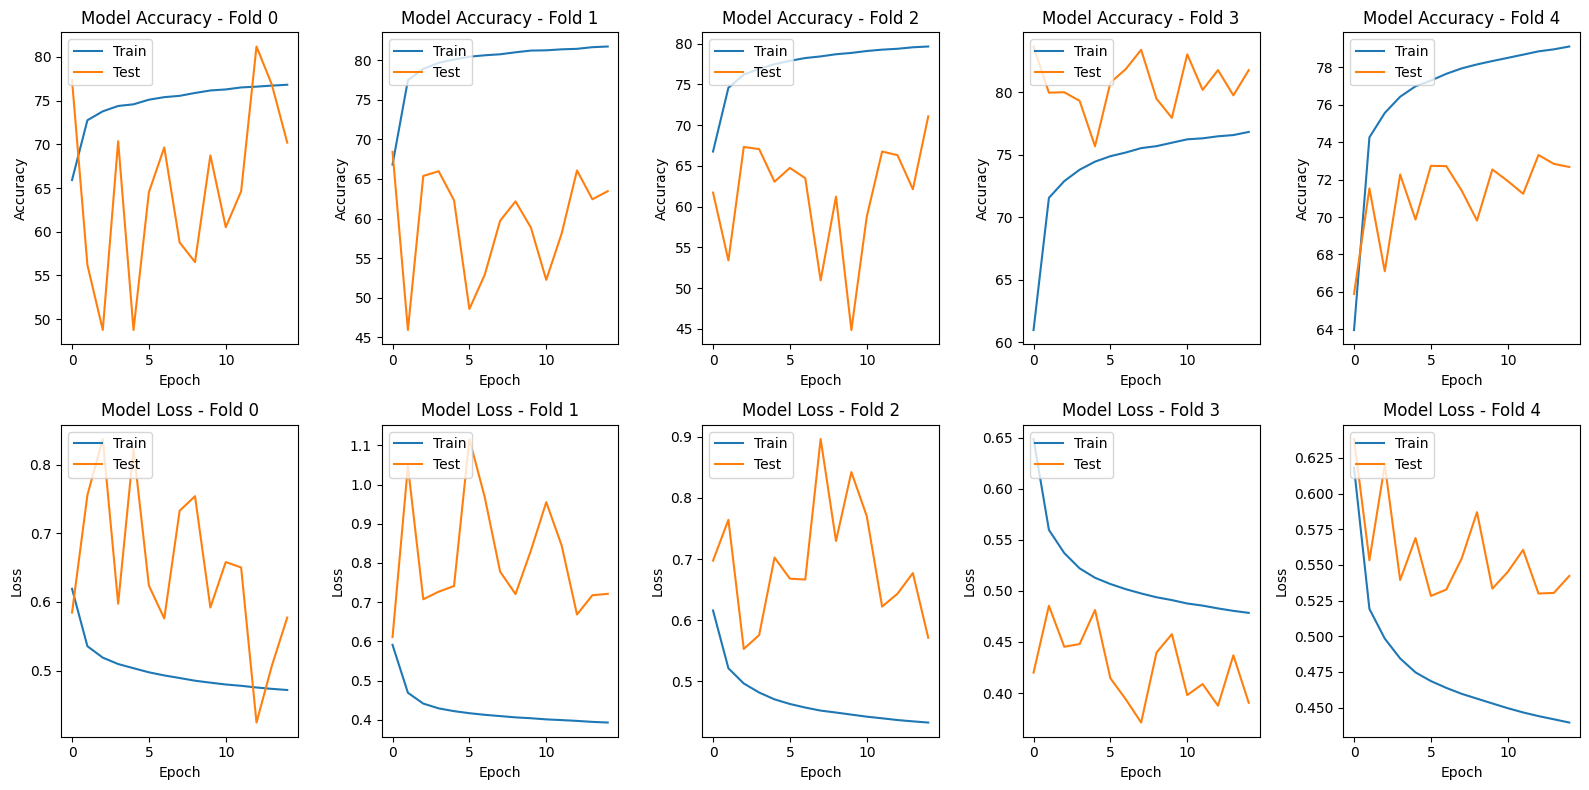

In [ ]:
# Creating subplots for accuracy and loss
fig, axs = plt.subplots(2, config.FOLDS, figsize=(16, 8))

for fold in range(config.FOLDS):
    axs[0, fold].plot(train_accs_list[fold])
    axs[0, fold].plot(val_accs_list[fold])
    axs[0, fold].set_title(f'Model Accuracy - Fold {fold}')
    axs[0, fold].set_ylabel('Accuracy')
    axs[0, fold].set_xlabel('Epoch')
    axs[0, fold].legend(['Train', 'Test'], loc='upper left')

    axs[1, fold].plot(train_losses_list[fold])
    axs[1, fold].plot(val_losses_list[fold])
    axs[1, fold].set_title(f'Model Loss - Fold {fold}')
    axs[1, fold].set_ylabel('Loss')
    axs[1, fold].set_xlabel('Epoch')
    axs[1, fold].legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# 4. Inference

In [ ]:
# Loading the model
VOCAB_SIZE = len(dataset.source_vocab)
HIDDEN_DIM = 128
OUTPUT_DIM = 1
VOCAB = list(dataset.source_vocab.stoi)
embedding_layer = get_emb_layer_with_weights(target_vocab=VOCAB, emb_model=fasttext_model, trainable=False)

model = Model(VOCAB_SIZE, config.EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, embedding_layer)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/NLP/best_model.pt'))

Words found are : 10000
Embedding(10000, 100)


<All keys matched successfully>

In [ ]:
## These functions help preprocess text data for input into a neural network

# Converts text into a list of numerical tokens using the vocabulary, adding special tokens like <SOS> and <EOS>
def numericalize(text):
    numerialized_source = []
    numerialized_source = [dataset.source_vocab.stoi["<SOS>"]]
    numerialized_source += dataset.source_vocab.numericalize(text)
    numerialized_source.append(dataset.source_vocab.stoi["<EOS>"])

    return numerialized_source

# Ensures that the input sequence is of a fixed length by either truncating or zero-padding the sequence as needed.
def padding(source):
    padded_sequence = torch.zeros(config.MAX_LEN, 1, dtype = torch.int)
    source = torch.tensor(source)

    if len(source) > config.MAX_LEN:
        padded_sequence[:, 0] = source[: config.MAX_LEN]
    else:
        padded_sequence[:len(source), 0] = padded_sequence[:len(source), 0] + source

    return padded_sequence

In [ ]:
# Function used for processing text data before performing inference with a neural network
def infer_processing(text):
    text = clean_text(text)
    text = numericalize(text)
    text = padding(text)
    return text

In [ ]:
random.seed(33)

# Create an empty list to store the information as dictionaries
results_data = []

# Sample random sentences
sample = random.sample(list(df_under['comment']), k=25)

for sentence in sample:
    row = df_under[df_under['comment'] == sentence].iloc[0]  # Get the entire row

    # Process the sentence
    a = infer_processing(sentence).to(config.DEVICE)

    model.eval()
    sentiment = model(a)
    sentiment = sentiment.cpu().detach().numpy()[0]

    sentiment_label = 'Positively' if sentiment > 0.5 else 'Negatively'

    # Create a dictionary with all the information
    result_dict = {
        'Comment': sentence,
        'fasttext_list': row['fasttext_list'],
        'fasttext_list2': row['fasttext_list2'],
        'prediction': row['prediction'],
        'aspect_spacy': row['spacy_pred'],
        'Sentiment': sentiment_label
    }

    results_data.append(result_dict)

# Create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_data)

In [ ]:
# Define a function to determine the new value for each row
def determine_new_value(row):
    values_to_check = [row['fasttext_list'], row['fasttext_list2'], row['prediction'], row['aspect_spacy']]
    unique_values = set(values_to_check)  # Get unique values in the list

    if 'general' in unique_values and len(unique_values) == 1:
        return 'general'
    else:
        unique_values.discard('general')  # Remove 'general' if it's present
        return ', '.join(unique_values)

# Create the new column based on the conditions
results_df['Aspects'] = results_df.apply(determine_new_value, axis=1)
results_df

,Comment,fasttext_list,fasttext_list2,prediction,aspect_spacy,Sentiment,Aspects
0,"This game has left me cold, to the point where...",general,general,general,general,Positively,general
1,"It's much better with 4 than with more, even i...",general,general,general,general,Negatively,general
2,Really great filler game. Easy to teach and fu...,general,general,general,general,Positively,general
3,"I'm not a fan. It's pleasant enough, but there...",general,interaction,general,general,Negatively,interaction
4,"Pandemic, but looks worse but has a Cthulhu th...",bash the leader,general,general,general,Negatively,bash the leader
5,"w/ The Artisans of Naqala, Whims of the Sultan...",interaction,general,general,general,Negatively,interaction
6,The graphics for this game are just terrible -...,general,general,general,general,Negatively,general
7,"Wow, this was a surprise. Reminded me that Ab...",general,general,bookkeeping,general,Positively,bookkeeping
8,"A very exciting game with simple mechanics, ye...",general,general,general,general,Negatively,general
9,The ultimative racing game. The mother. You do...,general,general,general,general,Negatively,general
